# 1D gaussian toy model

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

In [3]:
import numpy as np
import triangle
from clerk.stats.distances import mahalanobis
import abcpmc 

#np.random.seed(987654321)

# Data

In [4]:
mean = 1
sigma = 1
n = 10000
y = np.random.normal(mean, sigma, n)

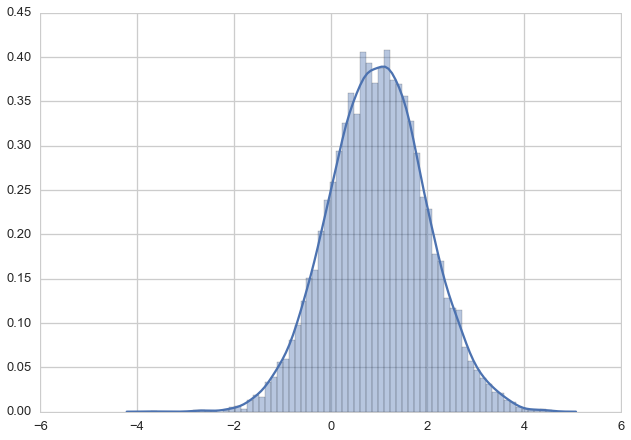

In [5]:
sns.distplot(y)

# Setup

In [6]:
prior = abcpmc.TophatPrior([-5], [5])

In [7]:
def mean_dist(x, y):
    return np.abs(np.mean(x, axis=0) - np.mean(y, axis=0))

dist = mean_dist

In [8]:
def create_new_sample(theta):
    return np.random.normal(theta, sigma, n)
postfn = create_new_sample

# Verification

In [9]:
theta = prior()
print theta
x = postfn([mean])
d = dist(x, y)
print d

[ 3.64242503]
0.0275573449992


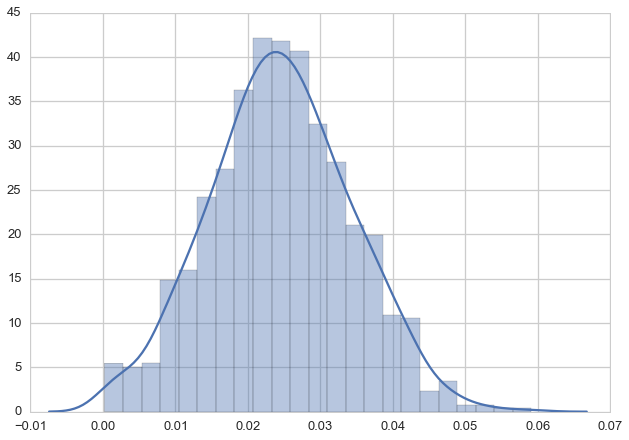

In [10]:
distances = [dist(y, postfn(mean)) for _ in range(1000)]
sns.distplot(distances)

# ABC sampling with PMC

In [12]:
def sample(T, eps_val, eps_min):
    abcpmc_sampler = abcpmc.Sampler(N=2000, Y=y, postfn=postfn, dist=dist, threads=8)
    eps = abcpmc.ConstEps(T, eps_val)
    pools = []
    for pool in abcpmc_sampler.sample(prior, eps):
        print("T: {0}, eps: {1:>.4f}, ratio: {2:>.4f}".format(pool.t, eps(pool.t), pool.ratio))
        
        eps.eps = np.percentile(pool.dists, 90)
        if eps.eps < eps_min:
            eps.eps = eps_min
            
        pools.append(pool)
        
    abcpmc_sampler.close()
    
    return pools


In [13]:
T=38
eps=0.5
pools = sample(T, eps, sigma/sqrt(n))

T: 0, eps: 0.5000, ratio: 0.0933
T: 1, eps: 0.4424, ratio: 0.6160
T: 2, eps: 0.3877, ratio: 0.6081
T: 3, eps: 0.3405, ratio: 0.5851
T: 4, eps: 0.2945, ratio: 0.6046
T: 5, eps: 0.2517, ratio: 0.6227
T: 6, eps: 0.2245, ratio: 0.6390
T: 7, eps: 0.1882, ratio: 0.5947
T: 8, eps: 0.1673, ratio: 0.5915
T: 9, eps: 0.1482, ratio: 0.6141
T: 10, eps: 0.1380, ratio: 0.6081
T: 11, eps: 0.1210, ratio: 0.6651
T: 12, eps: 0.1074, ratio: 0.5858
T: 13, eps: 0.0957, ratio: 0.6033
T: 14, eps: 0.0824, ratio: 0.5669
T: 15, eps: 0.0719, ratio: 0.5961
T: 16, eps: 0.0623, ratio: 0.5929
T: 17, eps: 0.0552, ratio: 0.5782
T: 18, eps: 0.0486, ratio: 0.6240
T: 19, eps: 0.0401, ratio: 0.5739
T: 20, eps: 0.0365, ratio: 0.5947
T: 21, eps: 0.0321, ratio: 0.5812
T: 22, eps: 0.0279, ratio: 0.5328
T: 23, eps: 0.0253, ratio: 0.5701
T: 24, eps: 0.0222, ratio: 0.5112
T: 25, eps: 0.0192, ratio: 0.4867
T: 26, eps: 0.0171, ratio: 0.4435
T: 27, eps: 0.0147, ratio: 0.4321
T: 28, eps: 0.0134, ratio: 0.4139
T: 29, eps: 0.0124, rati

# Postprocessing

In [14]:
def plot_pool(prob, samples):
    prob = np.array(prob).flatten()
    samples = np.vstack(samples)
    
    sns.distplot(prob)
    show()
    sns.distplot(samples, axlabel=r'$\theta$')
    #savefig("1d_gauss_posterior.pdf")
    show()
    sample_mean = np.mean(samples, axis=0)
    print(u"mean: {0:>.4f} \u00B1 {1:>.4f}".format(float(np.mean(samples, axis=0)), float(np.std(samples, axis=0))))


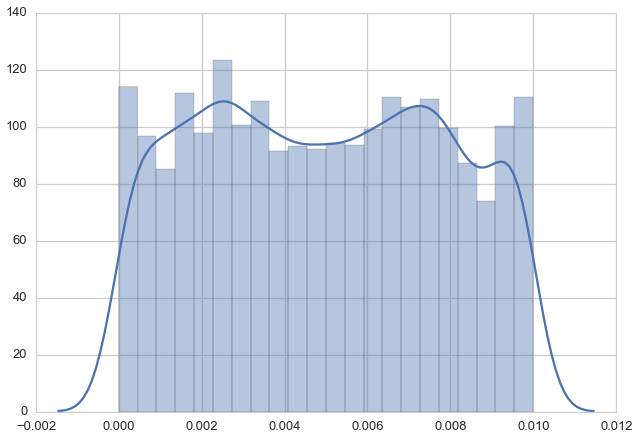

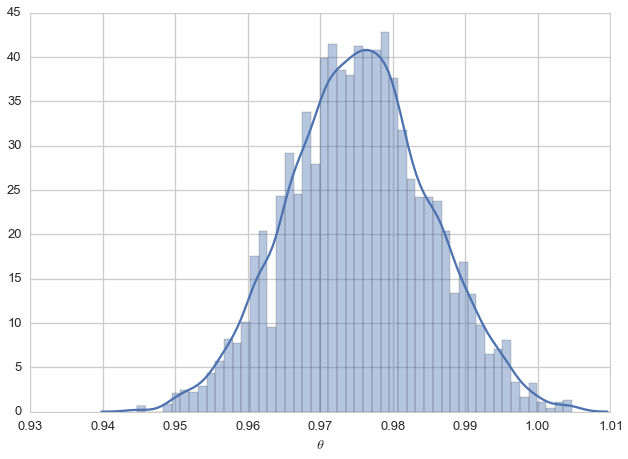

mean: 0.9755 ± 0.0097


In [15]:
offset = 33
samples = np.array([pool.thetas for pool in pools])
distances = np.array([pool.dists for pool in pools])

plot_pool(distances[offset:], samples[offset:])

In [16]:
var_vals = np.var((samples), axis=1)
eps_values = np.array([pool.eps for pool in pools])

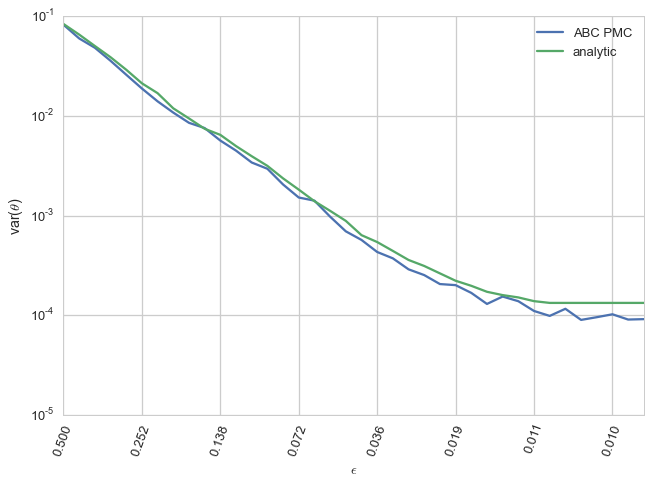

In [26]:
max_eps = 38
plot(var_vals[:max_eps], label="ABC PMC")

plot((float(sigma)**2/n + eps_values[:max_eps]**2/3), label="analytic")

ticks = xticks()[0][:-1]
xticks(ticks, ["{0:>4.3f}".format(eps) for eps in eps_values[ticks.tolist()]], rotation=70)
semilogy()
ylabel(r"var($\theta$)")
xlabel(r"$\epsilon$")
legend(loc="best")

savefig("1d_gauss_variance.pdf")

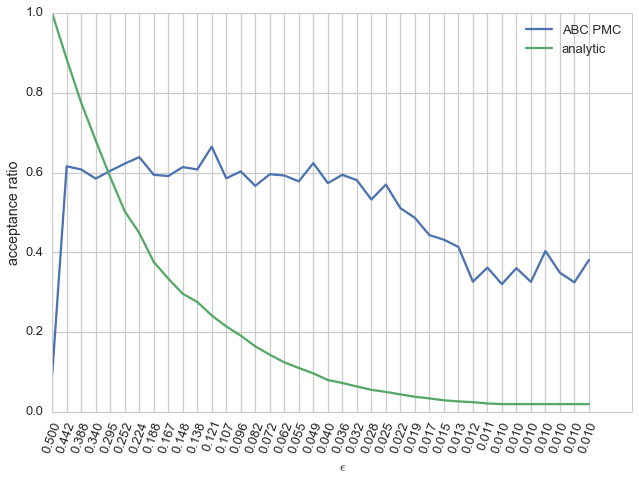

In [18]:
acc_ratios = np.array([pool.ratio for pool in pools])
plot(acc_ratios, label="ABC PMC")
plot(2 * np.array(eps_values), label="analytic")
xticks(np.arange(len(eps_values)), ["{0:>4.3f}".format(eps) for eps in eps_values], rotation=70)
#semilogy()
ylabel("acceptance ratio")
xlabel(r"$\epsilon$")
legend(loc="best")

In [19]:
from scipy.special import erf
def p_theta_eta(theta, eta):
    phi = lambda t: (1 + erf(t / np.sqrt(2))) / 2
    ybar = np.mean(y, axis=0)
    return 1. / (2 * eta) *(phi((ybar - theta + eta) / (sigma / np.sqrt(n))) - phi((ybar - theta - eta) / (sigma / np.sqrt(n))) )

In [20]:
def get_ticks(ticks, num=7):
    return [float("{0:<.2f}".format(tick)) for tick in np.linspace(ticks[0], ticks[-1], 7)]

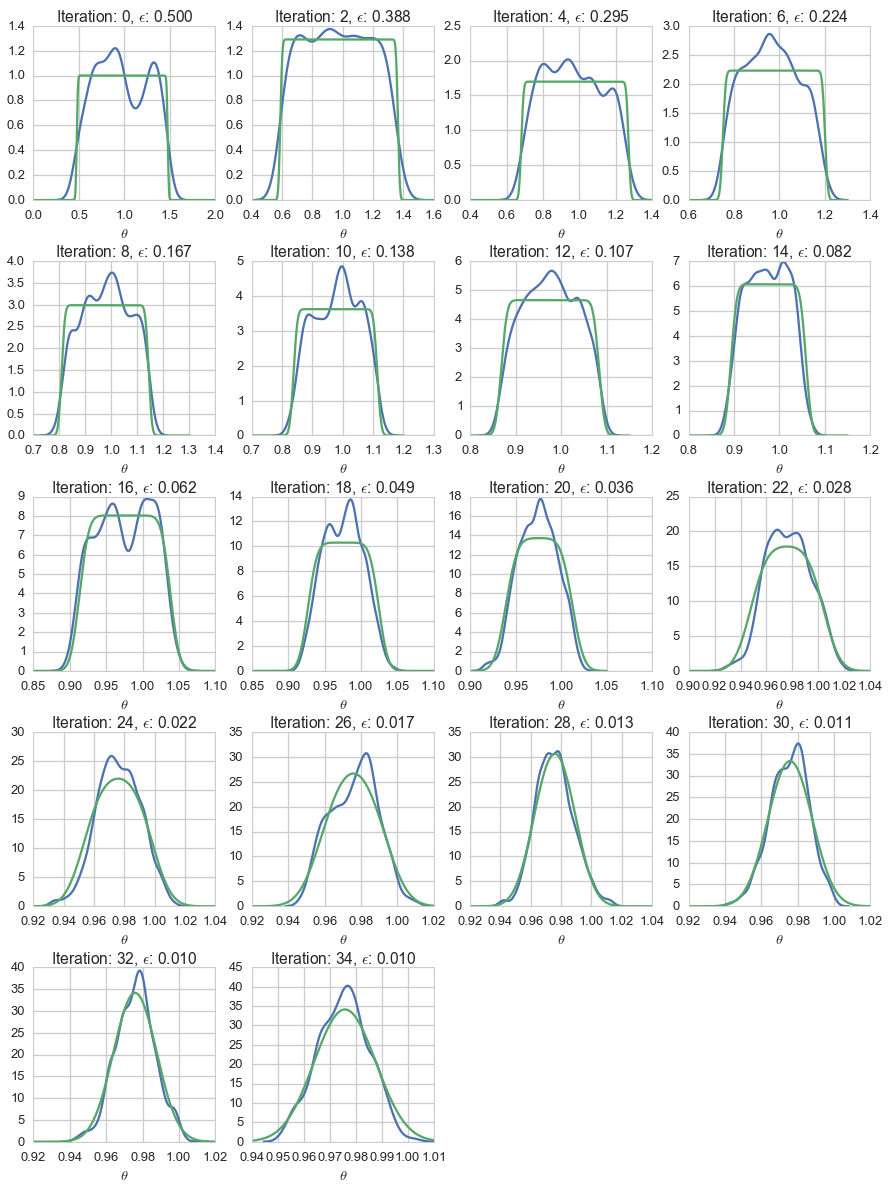

In [25]:
nbins = 7
with mpl.rc_context(rc={"figure.figsize": [15, 20]}):
    for i in range(36/2):
        subplot(5, 4, i+1)
        title(r"Iteration: {0}, $\epsilon$: {1:>4.3f}".format(i*2, eps_values[i*2]))
        ax = sns.distplot(samples[i*2], hist=False, axlabel=r'$\theta$', hist_kws={"rotation":.3})
        ax.locator_params(axis = 'x', nbins = nbins)
        #ax.locator_params(axis = 'y', nbins = nbins)
        min_val, max_val = ax.get_xlim()
        x_grid = np.linspace(min_val, max_val, 1000)
        plot(x_grid, p_theta_eta(x_grid, eps_values[i*2]))
        
    #i = 37
    #subplot(5, 4, 20)
    #title(r"Iteration: {0}, $\epsilon$: {1:>4.3f}".format(i, eps_values[i]))
    #ax = sns.distplot(samples[i], hist=False, axlabel=r'$\theta$')
    #ax.locator_params(axis = 'x', nbins = nbins)
    #min_val, max_val = ax.get_xlim()
    #x_grid = np.linspace(min_val, max_val, 1000)
    #plot(x_grid, p_theta_eta(x_grid, eps_values[i]))
    subplots_adjust(hspace = 0.35)
    savefig("1d_gauss_posterior_evolution.pdf")

In [20]:
from scipy.stats import gaussian_kde

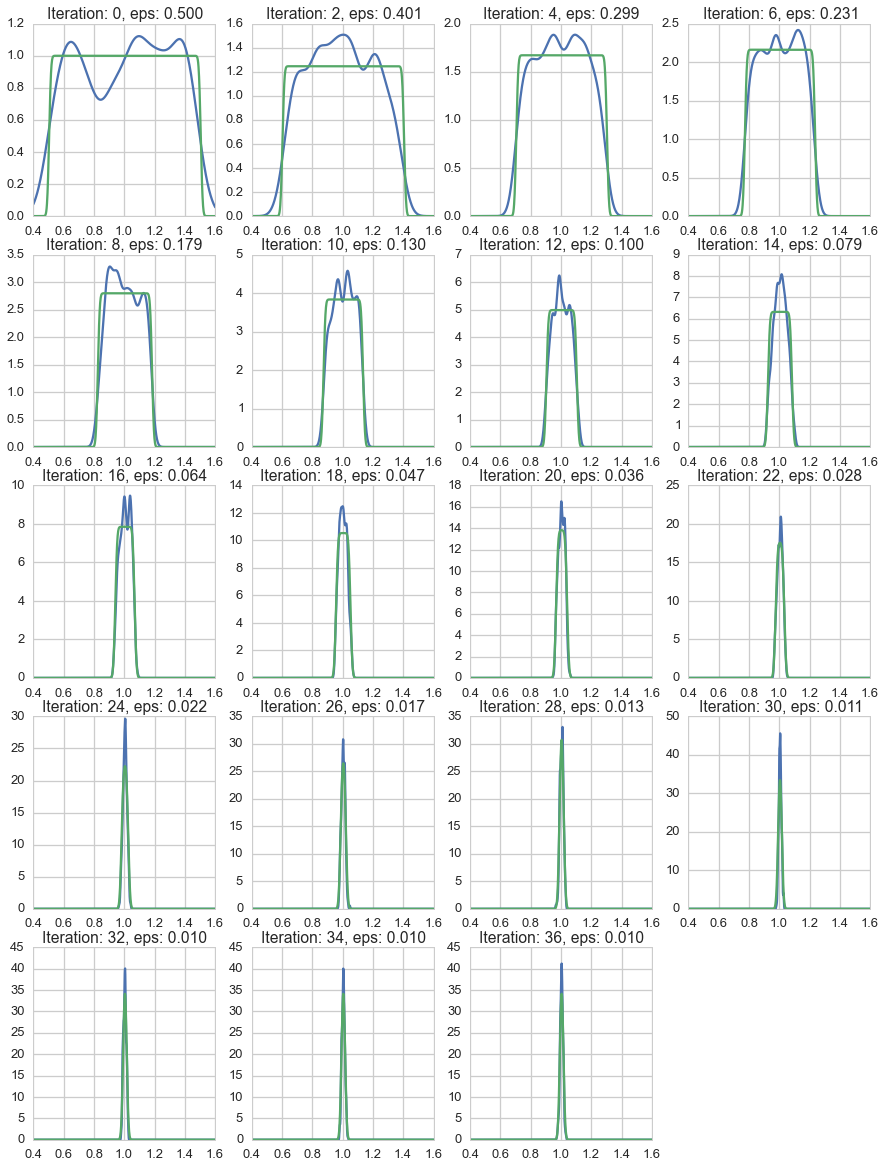

In [21]:
x_grid = np.linspace(0.4, 1.6, 1000)
with mpl.rc_context(rc={"figure.figsize": [15, 20]}):
    for i in range(len(samples)/2):
        subplot(5, 4, i+1)
        title("Iteration: {0}, eps: {1:>4.3f}".format(i*2, eps_values[i*2]))
        
        kde = gaussian_kde(np.array(samples[i*2])[:, 0])
        plot(x_grid, kde(x_grid))
        plot(x_grid, p_theta_eta(x_grid, eps_values[i*2]))